In [2]:
import pandas as pd 
import os 



In [3]:
os.getcwd()

'C:\\Users\\BADOHOUN\\Documents\\Multimodalité_APR\\Untitled Folder'

In [4]:

import numpy as np
names = ["col%i"%(i) for i in np.arange(8)]
Trajet_Speed_lisser_df = pd.read_csv("C:\\Users\\BADOHOUN\\Documents\\Multimodalité_APR\\gabrawdata (2).csv" , engine = 'python')
Trajet_Speed_lisser_df.columns = ["timestamp" , "deviceid" , "latitude" , "longitude" , "altitude" , "bearing" , "speed" , "accuracy" ]




Trajet_Speed_lisser_df = Trajet_Speed_lisser_df[['timestamp' , 'speed' , 'accuracy' , 'latitude','longitude']]


Trajet_Speed_lisser_df.head()




,timestamp,speed,accuracy,latitude,longitude
0,1517828318448,0.0,18.065,48.898518,2.377969
1,1517828323487,0.0,18.065,48.898518,2.377969
2,1517828328525,0.0,18.065,48.898518,2.377969
3,1517828333555,0.0,18.065,48.898518,2.377969
4,1517828338579,0.0,18.065,48.898518,2.377969


In [5]:
bus = pd.read_csv("C:\\Users\\BADOHOUN\\Downloads\\accessibilite-des-arrets-de-bus-ratp.csv", sep = ";" , header = 0 )
bus.columns = ['IDPTAR' , 'Nom Arrêt' , 'INSEE' , 'Departement' , 
               'X',  'Y' ,  'AccessUFR' , 'SonorePP', 
               'VisuellePP' ,'SonoreSP' , 
               'Visuelle SP' , 'Code Stif' , 'coord',
               'ID AMIVIF',  'PAQT',  'Téléphone' , 'Dateaccessibilité', 
               'QuaiTrain' , 'Sens' , 'Ligne']

station_bus_df = bus = bus[['Nom Arrêt' , 'Departement' , 'X' , 'Y',  'coord' ,'Sens' , 'Ligne' ]]


station_bus_df = station_bus_df.iloc[10:200,]


station_bus_df.shape


station_bus_df.head()


## détection de multimodalité avec jupyter , l'objectif est de reconnaitre avec précision les 


Position_bus1 = station_bus_df.iloc[:,4]
Position_bus2 = station_bus_df.iloc[:,0]

station_bus_df1 = pd.concat([Position_bus1 , Position_bus2] , axis = 1)


station_bus_df1.columns = ["LatitudeLongitude" , "Station"]

station_bus_df1.head()
bus_stop =  pd.DataFrame(station_bus_df1.LatitudeLongitude.str.split(' ',1).tolist(), 
                       columns = ['Latitude','Longitude'], index = station_bus_df.index)
bus_stop['Latitude'] = [x.replace("," , "") for x in bus_stop['Latitude']]

bus_stop['Station'] = station_bus_df1.Station
bus_stop['ligne'] = station_bus_df['Ligne']

bus_stop['Departement'] = station_bus_df['Departement']
bus_stop['Sens'] = station_bus_df['Sens']
bus_stop.head()




,Latitude,Longitude,Station,ligne,Departement,Sens
10,48.9458344094,2.34711898511,DELAUNAY-BELLEVILLE,18.0,93,R
11,48.9495012103,2.33028231892,LES MOBILES,18.0,93,R
12,48.9561424298,2.34360020611,PABLO NERUDA,18.0,93,A
13,48.9559330378,2.31109484217,LACEPEDE,18.0,93,R
14,48.7682932813,2.36780702307,BRETAGNE,17.0,94,R


In [6]:
#formula to calculate distance among two gps points
def haversine(coord1,coord2):
    import math
    sin = math.sin
    cos = math.cos
    atan2 = math.atan2
    sqrt = math.sqrt
    
    lon1,lat1=coord1
    lon2,lat2=coord2
    R=6371000 #metres
    phi1=lat1 * (3.1415 / 180)
    phi2=lat2 * (3.1415 / 180)
    Dphi= phi2 - phi1
    Dlambda = (lon2 -lon1) *  (3.1415 / 180)

    a = sin(Dphi / 2) ** 2 + cos(phi1)*cos(phi2) *sin(Dlambda/2)**2
    c = 2 * atan2(sqrt(a),sqrt(1-a))
    d = R*c
    return d

In [7]:
station_bus_coord = {}

for data in bus_stop.iterrows():
    ligne = data[1]
    if ligne['Station'] not in  bus_stop['Station'].values :
        continue 
    else :
        station_bus_coord[ligne['Station']] = (float(ligne['Latitude']) ,float(ligne['Longitude']))
        
        
    


## Comme la terre n’est pas parfaitement sphérique, 
## la formule de Vincenty pour les ellipsoïdes est probablement la meilleure façon de calculer les distances. 
## Ainsi, dans le package Vincenty , on utilise  alors : distm(p1, p2) 
## ou p1 et p2 réprésente les coordonnées gps 

In [8]:
from vincenty import vincenty


def trajet_proche(emplacement, emplacement_dict):
    """ on prend un tuple de latitude et de longitude et on le compare à un dictionnaire de lieux où clé = nom de station et valeur = (lat, long) 
    renvoie un tuple de (lieu le plus proche, distance) """
    trajet_proche = None
    for station_bus  in emplacement_dict.keys():
        dist = vincenty(emplacement, emplacement_dict[station_bus])
        if  trajet_proche is None:
            trajet_proche = (station_bus, dist)
        elif dist < trajet_proche[1]:
            trajet_proche = (station_bus, dist)
    return trajet_proche

In [9]:
Trajet_Speed_lisser_df['trajet_proche']= Trajet_Speed_lisser_df.apply(lambda x : trajet_proche((x['latitude'], x['longitude']), station_bus_coord),axis = 1) 
Trajet_Speed_lisser_df.head()






,timestamp,speed,accuracy,latitude,longitude,trajet_proche
0,1517828318448,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)"
1,1517828323487,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)"
2,1517828328525,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)"
3,1517828333555,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)"
4,1517828338579,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)"


In [10]:
Trajet_Speed_lisser_df = Trajet_Speed_lisser_df.drop_duplicates()
Trajet_Speed_lisser_df.tail(5)

,timestamp,speed,accuracy,latitude,longitude,trajet_proche
148169,1554191264933,4.345855,13.391,48.896233,2.373881,"(ROSA PARKS, 0.17538)"
148170,1554191265938,2.041442,12.087,48.896248,2.373865,"(ROSA PARKS, 0.173329)"
148171,1554191266946,3.125705,10.789,48.896275,2.373851,"(ROSA PARKS, 0.170303)"
148172,1554191267945,0.932715,10.288,48.896282,2.373846,"(ROSA PARKS, 0.169396)"
148173,1554191268945,1.427828,10.044,48.896294,2.373837,"(ROSA PARKS, 0.16799)"


In [11]:
Trajet_Speed_lisser_df['Arret'] = [t[0] for t in Trajet_Speed_lisser_df.trajet_proche]

Trajet_Speed_lisser_df['distance_arret'] = [t[1] for t in Trajet_Speed_lisser_df.trajet_proche]
Trajet_Speed_lisser_df['distance_arret'] = [t[1] for t in Trajet_Speed_lisser_df.trajet_proche]

Trajet_Speed_lisser_df.head()

,timestamp,speed,accuracy,latitude,longitude,trajet_proche,Arret,distance_arret
0,1517828318448,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)",ROSA PARKS,0.416844
1,1517828323487,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)",ROSA PARKS,0.416844
2,1517828328525,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)",ROSA PARKS,0.416844
3,1517828333555,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)",ROSA PARKS,0.416844
4,1517828338579,0.0,18.065,48.898518,2.377969,"(ROSA PARKS, 0.416844)",ROSA PARKS,0.416844


In [ ]:
def speeds(polyline):
    N=len(polyline)
    v = [0.]*N
    #lon =[]*N
    #Lat =[]*N
    if N == 0:
        return []
    
    for i in range(N - 1):
        v[i] = haversine(polyline[i],polyline[i+1]) / 15.
        #lon[i] = polyline[i]
        #lat[i] = polyline[i+1]
    
    v[N-1]  = haversine(polyline[N-1],polyline[N-2]) / 15.
    
    return v
    #return v,lon,lat


In [33]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8)

C:\Users\BADOHOUN\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [62]:
from sklearn.cluster import DBSCAN

db1 = DBSCAN(eps = .6, min_samples = 3)
db1.fit(scale(test_df[test_df.columns[:5]]))



C:\Users\BADOHOUN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [63]:
db1.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1,  0,  0,  0,  0

In [64]:
eff = numpy.unique(db1.labels_, return_counts = True)
pandas.DataFrame({
    "Classe" : eff[0],
    "Effectif" : eff[1],
     "Pourcentage" : [str(numpy.round(e / numpy.sum(eff[1]) * 100, 1)) + "%" for e in eff[1]]
})

,Classe,Effectif,Pourcentage
0,-1,6,0.9%
1,0,346,53.3%
2,1,297,45.8%


In [65]:
test_df_pca_db1 = test_df_pca_df.assign(Labels = db1.labels_)

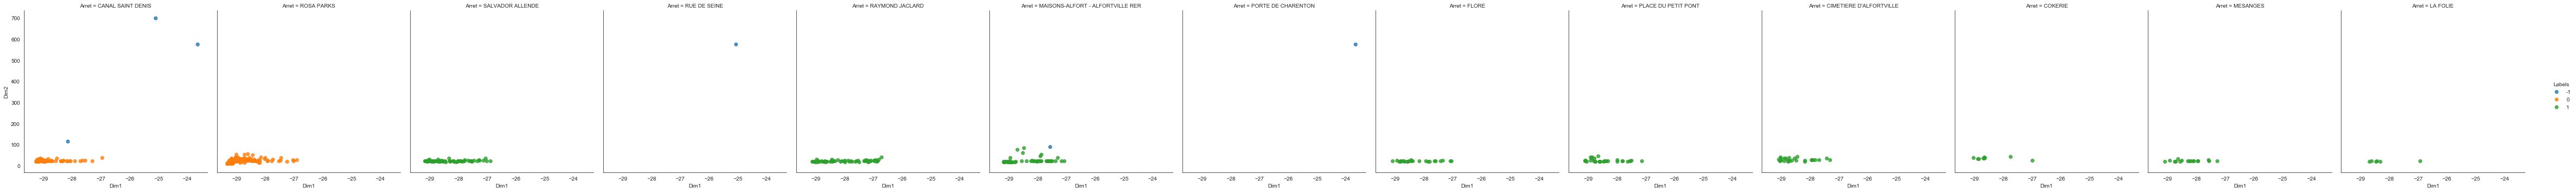

In [66]:
seaborn.lmplot("Dim1", "Dim2", hue = "Labels", col = "Arret", data = test_df_pca_db1 , fit_reg = False)

In [67]:
X = test_df_pca_db1.iloc[:,0:3]

y = test_df_pca_db1.Arret

In [68]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test = train_test_split(X,y)

In [ ]:
from sklearn import neighbors 

knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train , y_train)

In [69]:
from sklearn import neighbors 

knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train , y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [70]:
y_pred = knn.predict_proba(X_test)


In [71]:
knn.score(X_test,y_test)

0.44171779141104295

In [72]:
knn.predict(X_test)


array(['ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS', 'RAYMOND JACLARD',
       'CANAL SAINT DENIS', 'MAISONS-ALFORT - ALFORTVILLE RER',
       'ROSA PARKS', 'ROSA PARKS', 'MAISONS-ALFORT - ALFORTVILLE RER',
       'CANAL SAINT DENIS', 'SALVADOR ALLENDE', 'CANAL SAINT DENIS',
       'ROSA PARKS', "CIMETIERE D'ALFORTVILLE", 'CANAL SAINT DENIS',
       'ROSA PARKS', 'SALVADOR ALLENDE', 'SALVADOR ALLENDE', 'COKERIE',
       'CANAL SAINT DENIS', 'PLACE DU PETIT PONT',
       "CIMETIERE D'ALFORTVILLE", 'ROSA PARKS', 'CANAL SAINT DENIS',
       'ROSA PARKS', 'CANAL SAINT DENIS', 'SALVADOR ALLENDE',
       'ROSA PARKS', 'FLORE', 'SALVADOR ALLENDE', 'CANAL SAINT DENIS',
       'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS',
       'ROSA PARKS', 'ROSA PARKS', 'SALVADOR ALLENDE',
       'CANAL SAINT DENIS', 'ROSA PARKS', "CIMETIERE D'ALFORTVILLE",
       'SALVADOR ALLENDE', 'ROSA PARKS', 'ROSA PARKS', 'FLORE',
       'ROSA PARKS', 'CANAL SAINT DENIS', 'ROSA PARKS',
       'MAISONS-ALFORT - AL

In [102]:
X1 = test_df[test_df.columns[:5]]

y1 = test_df['Arret']

In [103]:
from sklearn.model_selection import train_test_split


X_train,X_test,y_train,y_test = train_test_split(X1,y1)

In [104]:
from sklearn import neighbors 

knn = neighbors.KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train , y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [105]:
y_pred = knn.predict_proba(X_test)


In [106]:
knn.score(X_test,y_test)

0.43558282208588955

In [107]:
knn.predict(X_test)


array(['ROSA PARKS', 'CANAL SAINT DENIS', 'SALVADOR ALLENDE',
       'ROSA PARKS', 'ROSA PARKS', 'RAYMOND JACLARD', 'ROSA PARKS',
       'RAYMOND JACLARD', "CIMETIERE D'ALFORTVILLE", 'CANAL SAINT DENIS',
       'SALVADOR ALLENDE', 'ROSA PARKS', 'PLACE DU PETIT PONT',
       'CANAL SAINT DENIS', 'SALVADOR ALLENDE', 'ROSA PARKS',
       'CANAL SAINT DENIS', 'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS',
       'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS',
       'ROSA PARKS', 'RAYMOND JACLARD', 'ROSA PARKS', 'ROSA PARKS',
       'SALVADOR ALLENDE', 'ROSA PARKS', 'ROSA PARKS',
       'MAISONS-ALFORT - ALFORTVILLE RER', 'CANAL SAINT DENIS',
       'MAISONS-ALFORT - ALFORTVILLE RER', 'CANAL SAINT DENIS',
       'ROSA PARKS', 'ROSA PARKS', 'ROSA PARKS', 'RAYMOND JACLARD',
       'ROSA PARKS', 'CANAL SAINT DENIS', 'CANAL SAINT DENIS',
       'CANAL SAINT DENIS', 'ROSA PARKS',
       'MAISONS-ALFORT - ALFORTVILLE RER', 'ROSA PARKS', 'COKERIE',
       'FLORE', 'RAYMOND JACLARD', 'CANAL SAI

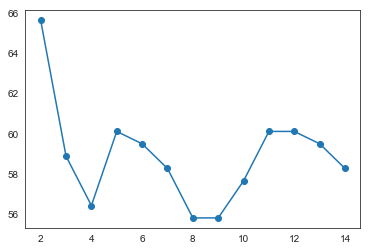

In [90]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

Comme on peut le voir, le k-NN le plus performant est celui pour lequel k = 5. 
On connaît donc notre classifieur final optimal : 5-nn. Ce qui veut dire que c'est celui qui classifie le mieux les données

In [91]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(7)
knn.fit(X_train, y_train)

# On récupère les prédictions sur les données test
predicted = knn.predict(X_test)



In [87]:
knn.score(X_test,y_test)

0.3987730061349693

In [108]:
# Créer une SVM avec un noyau gaussien de paramètre gamma=0.01
from sklearn import svm
classifier = svm.SVC(kernel='rbf', gamma=0.01)

# Entraîner la SVM sur le jeu d'entraînement
classifier.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [109]:
# prédire sur le jeu de test
y_test_pred = classifier.decision_function(X_test)

y_test_pred

array([[10.4164715 ,  7.07127342,  0.68290839, ..., 11.48531734,
        -0.40072285,  9.24788236],
       [ 9.23587919,  2.83845659,  0.62730301, ..., 11.32940121,
        -0.41628739, 10.33480761],
       [10.25986459,  2.84558691,  0.62160699, ..., 11.35043901,
        -0.41460457,  9.3193765 ],
       ...,
       [10.36775682,  2.96586157,  0.63400202, ..., 11.43904978,
        -0.41098816,  9.28103562],
       [ 8.21455671,  2.81790671,  0.62943798, ..., 11.31382106,
        -0.41469563, 10.33778154],
       [10.31891305,  2.90019372,  0.62140044, ..., 11.39765669,
        -0.41411357,  9.30045326]])

In [14]:
os.chdir("C://Users//BADOHOUN/Downloads/")

In [309]:

names = ["col%i"%(i) for i in np.arange(8)]

df = pd.read_csv("multimodal_analytics2.csv" , names = names  , parse_dates=[0] , index_col = 0)

df.head()

,col1,col2,col3,col4,col5,col6,col7
col0,,,,,,,
1517828313422,123fe0be9804,48.898518,2.377969,0,0,0.0,18.065001
1517828318448,123fe0be9804,48.898518,2.377969,0,0,0.0,18.065001
1517828323487,123fe0be9804,48.898518,2.377969,0,0,0.0,18.065001
1517828328525,123fe0be9804,48.898518,2.377969,0,0,0.0,18.065001
1517828333555,123fe0be9804,48.898518,2.377969,0,0,0.0,18.065001


In [24]:
import pandas as pd 
import numpy as np

import os
os.getcwd()

'C:\\Users\\BADOHOUN\\Documents\\Multimodalité_APR\\Untitled Folder'

In [25]:


data_apr_paris = pd.read_csv('C:\\Users\\BADOHOUN\\Documents\\Multimodalité_APR\\trajet_paris.csv' , encoding = "utf-16" , sep = "\t")
data_apr_paris.tail()

,Colonne 1,Colonne 2,Colonne 3,Colonne 4,Colonne 5,Colonne 6,Colonne 7,Colonne 8,Colonne 9,Colonne 10,Colonne 11,Colonne 12,Colonne 13,Colonne 14,Colonne 15,Colonne 16,Colonne 17,Colonne 18,Colonne 19,"""Filtrés par"" à 18:10:04"
8032,3_D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,1543781995200,D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,48.902720,2.203626,29.407314,NaN,11.074065,-2.015898,50.0,motorway_link,NaN,False,22.0,86.0,NaN,Light drizzle,NaN,NaN,Oui
8033,3_D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,1543781997068,D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,48.902573,2.203153,30.254970,NaN,17.614408,3.557608,50.0,motorway_link,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,Oui
8034,3_D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,1543781999059,D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,48.902000,2.203041,30.137290,NaN,24.952080,3.746620,200.0,motorway,70.0,False,22.0,86.0,NaN,Light drizzle,NaN,NaN,Oui
8035,3_D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,1543782003077,D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,48.901768,2.202643,29.188969,NaN,16.269735,4.308180,200.0,motorway,70.0,False,NaN,NaN,NaN,NaN,NaN,NaN,Oui
8036,3_D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,1543782005086,D7FF691A-D6C5-436E-A7CD-A5A180D7D7ED,48.901527,2.202284,27.757603,NaN,14.945284,-2.579162,200.0,motorway,70.0,False,22.0,86.0,NaN,Light drizzle,NaN,NaN,Oui


In [26]:

data_apr_paris = df.iloc[0:90, ]
data_apr_paris.shape
data_apr_paris = data_apr_paris.iloc[:,:11]
data_apr_paris.head()

,Colonne 1,Colonne 2,Colonne 3,Colonne 4,Colonne 5,Colonne 6,Colonne 7,Colonne 8,Colonne 9,Colonne 10,Colonne 11
0,1_254a0530f70d7ece,1543669130000,254a0530f70d7ece,48.843647,2.132580,176.159866,211.0,0.000000,0.000000,3.9,secondary
1,1_254a0530f70d7ece,1543669131000,254a0530f70d7ece,48.843540,2.132480,176.929413,211.0,0.000000,0.000000,3.9,secondary
2,1_254a0530f70d7ece,1543669132000,254a0530f70d7ece,48.843430,2.132379,177.684326,211.0,0.000000,0.000000,4.0,secondary
3,1_254a0530f70d7ece,1543669133000,254a0530f70d7ece,48.843327,2.132282,178.471000,211.0,13.835481,0.000000,4.0,secondary
4,1_254a0530f70d7ece,1543669134000,254a0530f70d7ece,48.843224,2.132182,179.314087,211.0,13.804829,16.158888,4.0,secondary


In [28]:
data_apr_paris.columns = ["deviceid_touttype" , "dateentry_touttype" , "deviceid_toutype", "latitude_trajet_touttype" , "longitude_trajet_touttype" , "altitude_touttype" , "bearing_touttype" , "speed_touttype" , "accuracy_touttype", "accelo_touttype" , "type_de_mode_touttype"]

data_apr_paris.head()

,deviceid_touttype,dateentry_touttype,deviceid_toutype,latitude_trajet_touttype,longitude_trajet_touttype,altitude_touttype,bearing_touttype,speed_touttype,accuracy_touttype,accelo_touttype,type_de_mode_touttype
0,1_254a0530f70d7ece,1543669130000,254a0530f70d7ece,48.843647,2.132580,176.159866,211.0,0.000000,0.000000,3.9,secondary
1,1_254a0530f70d7ece,1543669131000,254a0530f70d7ece,48.843540,2.132480,176.929413,211.0,0.000000,0.000000,3.9,secondary
2,1_254a0530f70d7ece,1543669132000,254a0530f70d7ece,48.843430,2.132379,177.684326,211.0,0.000000,0.000000,4.0,secondary
3,1_254a0530f70d7ece,1543669133000,254a0530f70d7ece,48.843327,2.132282,178.471000,211.0,13.835481,0.000000,4.0,secondary
4,1_254a0530f70d7ece,1543669134000,254a0530f70d7ece,48.843224,2.132182,179.314087,211.0,13.804829,16.158888,4.0,secondary


In [47]:
data_apr_paris['trajet_proche']= data_apr_paris.apply(lambda x : trajet_proche((x['latitude_trajet_touttype'], x['longitude_trajet_touttype']), station_bus_coord),axis = 1) 
data_apr_paris.head()

,dateentry_touttype,latitude_trajet_touttype,longitude_trajet_touttype,speed_touttype,distance_arret,arret,trajet_proche
0,1543669130000,48.843647,2.132580,0.000000,4.996039,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.996039)"
1,1543669131000,48.843540,2.132480,0.000000,4.989904,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.989904)"
2,1543669132000,48.843430,2.132379,0.000000,4.983560,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.98356)"
3,1543669133000,48.843327,2.132282,13.835481,4.977708,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.977708)"
4,1543669134000,48.843224,2.132182,13.804829,4.972043,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.972043)"


## Prepare the data

## Prepare the data

## Prepare the data

In [48]:


data_apr_paris['arret'] = [t[0] for t in data_apr_paris.trajet_proche]
data_apr_paris['distance_arret_apr'] = [t[1] for t in data_apr_paris.trajet_proche]

data_apr_paris.tail()

,dateentry_touttype,latitude_trajet_touttype,longitude_trajet_touttype,speed_touttype,distance_arret,arret,trajet_proche,distance_arret_apr
85,1543669215000,48.839977,2.126361,9.849461,4.931460,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.93146)",4.931460
86,1543669216000,48.839973,2.126262,8.704884,4.935728,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.935728)",4.935728
87,1543669217000,48.839970,2.126189,7.190743,4.938834,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.938834)",4.938834
88,1543669218000,48.839970,2.126154,5.135708,4.940465,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.940465)",4.940465
89,1543669219000,48.839970,2.126144,2.959425,4.940931,VIROFLAY - RIVE DROITE,"(VIROFLAY - RIVE DROITE, 4.940931)",4.940931


In [49]:
data_apr_paris = data_apr_paris[['dateentry_touttype'  , 'latitude_trajet_touttype', 'longitude_trajet_touttype' , 
                                   'speed_touttype'  , 'distance_arret_apr',
                                'arret']]
data_apr_paris.head()


## temps d'immobilité à la fin des trajets en véhicule 
## temps d'immobilité en tant que features 

,dateentry_touttype,latitude_trajet_touttype,longitude_trajet_touttype,speed_touttype,distance_arret_apr,arret
0,1543669130000,48.843647,2.132580,0.000000,4.996039,VIROFLAY - RIVE DROITE
1,1543669131000,48.843540,2.132480,0.000000,4.989904,VIROFLAY - RIVE DROITE
2,1543669132000,48.843430,2.132379,0.000000,4.983560,VIROFLAY - RIVE DROITE
3,1543669133000,48.843327,2.132282,13.835481,4.977708,VIROFLAY - RIVE DROITE
4,1543669134000,48.843224,2.132182,13.804829,4.972043,VIROFLAY - RIVE DROITE


In [51]:
Trajet_Speed_lisser_df = Trajet_Speed_lisser_df[['timestamp' , 'latitude', 'longitude'  ,'speed' ,  'distance_arret' , 'Arret']]
Trajet_Speed_lisser_df.head()

,timestamp,latitude,longitude,speed,distance_arret,Arret
0,1517828318448,48.898518,2.377969,0.0,0.416844,ROSA PARKS
1,1517828323487,48.898518,2.377969,0.0,0.416844,ROSA PARKS
2,1517828328525,48.898518,2.377969,0.0,0.416844,ROSA PARKS
3,1517828333555,48.898518,2.377969,0.0,0.416844,ROSA PARKS
4,1517828338579,48.898518,2.377969,0.0,0.416844,ROSA PARKS


In [59]:
test_data = pd.concat([data_apr_paris , Trajet_Speed_lisser_df] , axis = 1).dropna()
test_data.head()

,dateentry_touttype,latitude_trajet_touttype,longitude_trajet_touttype,speed_touttype,distance_arret_apr,arret,timestamp,latitude,longitude,speed,distance_arret,Arret
0,1.543669e+12,48.843647,2.132580,0.000000,4.996039,VIROFLAY - RIVE DROITE,1517828318448,48.898518,2.377969,0.0,0.416844,ROSA PARKS
1,1.543669e+12,48.843540,2.132480,0.000000,4.989904,VIROFLAY - RIVE DROITE,1517828323487,48.898518,2.377969,0.0,0.416844,ROSA PARKS
2,1.543669e+12,48.843430,2.132379,0.000000,4.983560,VIROFLAY - RIVE DROITE,1517828328525,48.898518,2.377969,0.0,0.416844,ROSA PARKS
3,1.543669e+12,48.843327,2.132282,13.835481,4.977708,VIROFLAY - RIVE DROITE,1517828333555,48.898518,2.377969,0.0,0.416844,ROSA PARKS
4,1.543669e+12,48.843224,2.132182,13.804829,4.972043,VIROFLAY - RIVE DROITE,1517828338579,48.898518,2.377969,0.0,0.416844,ROSA PARKS


In [79]:
 

if test_data['speed'] = 0 
    
np.mean(test_data.speed_touttype)

8.01856167177778

In [80]:
np.mean(test_data.speed)

0.08013635555555557

In [62]:
test_data["speed_touttype"]

0      0.000000
1      0.000000
2      0.000000
3     13.835481
4     13.804829
5     13.716930
6     13.783457
7     13.782561
8     13.779814
9     13.828432
10    13.814859
11    13.591723
12    13.122542
13    12.371981
14    11.585621
15    10.506276
16     9.299479
17     7.999129
18     6.820918
19     6.069674
20     5.743599
21     6.058273
22     6.658278
23     7.450565
24     8.045015
25     8.420927
26     8.346987
27     7.757311
28     6.945165
29     6.476391
        ...    
60     9.183601
61     9.530410
62     9.536698
63     8.943983
64     7.839194
65     6.491364
66     5.347773
67     4.620067
68     4.179778
69     3.611664
70     2.899556
71     2.115917
72     1.920878
73     2.620197
74     4.268010
75     5.851773
76     7.010482
77     7.685911
78     8.471970
79     9.256536
80     9.949582
81    10.555770
82    10.973960
83    11.031952
84    10.654442
85     9.849461
86     8.704884
87     7.190743
88     5.135708
89     2.959425
Name: speed_touttype, Le

## Quelques features basées sur les statistiques de la vitesse . 

On ne sait pas labelliser.

On est obligé d’apprendre en faisant. On part toujours de ce qu’on sait. Si on doit construire une classification sans savoir ce que sont les deux classes à prédire, 

on va essayer de regrouper les observations en deux classes puis essayer de comprendre si les deux groupes ainsi formés ont quelque chose à voir avec le problème initial quitte à ne pas savoir tout classer. 

On peut aussi essayer de trouver une autre source d’information pour construire quelques labels.

On veut parfois construire un système d’alerte qui doit prédire si une anomalie survient ? Mais on ne sait pas ce que c’est une anomalie. 

On regarde alors les événements extrêmes pour cerner un peu mieux puis petit à petit définir ce qu’on attend du modèle de prédiction.

In [ ]:
test_data["Illness"] = np.where(test_data["Illness"] == "No", 0, 1)

In [64]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

%matplotlib inline


from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale 

pca = PCA()
pca.fit(scale(test_data[["speed_touttype" , "speed"  ,"distance_arret_apr" , "distance_arret"]]))





PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [65]:
## L'objet pca comprend maintenant un certain nombre d'objets et de fonctions. 

## Le premier objet est le tableau des variances expliquées (explained_variance_) par chaque dimension
## et le ratio (proportion) de variance expliquée par dimension (explained_variance_ratio_).



print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[1.3148302  1.15921592 0.81205006 0.75884765]
[0.32505524 0.28658393 0.20075682 0.187604  ]


In [67]:
eig = pandas.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(4)], 
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : numpy.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : numpy.round(numpy.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
eig

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,Dim1,1.314830,33.0,33.0
1,Dim2,1.159216,29.0,61.0
2,Dim3,0.812050,20.0,81.0
3,Dim4,0.758848,19.0,100.0


Text(3.25, 26, '25%')

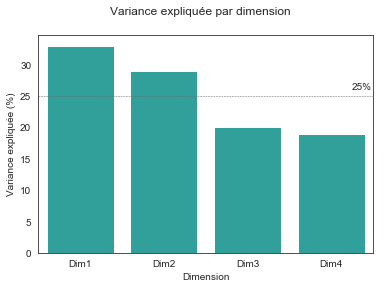

In [68]:
g_eig = seaborn.barplot(x = "Dimension", 
                y = "% variance expliquée",
                palette = ["lightseagreen"],
                data = eig)
g_eig.set(ylabel = "Variance expliquée (%)")
g_eig.figure.suptitle("Variance expliquée par dimension")
plt.axhline(y = 25, linewidth = .5, color = "dimgray", linestyle = "--") # 25 = 100 / 4 (nb dimensions)
plt.text(3.25, 26, "25%")

In [69]:
test_data_pca = pca.transform(test_data[["speed_touttype" , "speed"  ,"distance_arret_apr" , "distance_arret"]])

In [73]:
# Transformation en DataFrame pandas
test_data_pca_df = pandas.DataFrame({
    "Dim1" : test_data_pca[:,0], 
    "Dim2" : test_data_pca[:,1], 
    "Dim3" : test_data_pca[:,2],
    "Dim4" : test_data_pca[:,3],
    "Arret_trajetBus" : test_data.Arret,
    "Arret_trajetapr" : test_data.arret
})

# Résultat (premières lignes)
test_data_pca_df.head()

,Dim1,Dim2,Dim3,Dim4,Arret_trajetBus,Arret_trajetapr
0,-2.372823,2.463675,2.514960,-2.666300,ROSA PARKS,VIROFLAY - RIVE DROITE
1,-2.369612,2.460847,2.511700,-2.663351,ROSA PARKS,VIROFLAY - RIVE DROITE
2,-2.366292,2.457922,2.508328,-2.660301,ROSA PARKS,VIROFLAY - RIVE DROITE
3,-6.974580,11.589910,-5.105770,2.707804,ROSA PARKS,VIROFLAY - RIVE DROITE
4,-6.961399,11.567060,-5.091919,2.698641,ROSA PARKS,VIROFLAY - RIVE DROITE


Text(0.5, 0.98, 'Premier plan factoriel')

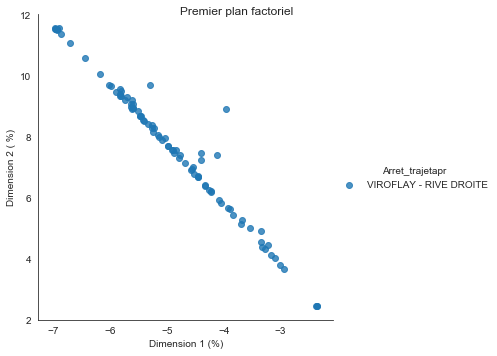

In [77]:
g_pca = seaborn.lmplot("Dim1", "Dim2", hue = "Arret_trajetapr", data = test_data_pca_df, fit_reg = False)
g_pca.set(xlabel = "Dimension 1 (%)", ylabel = "Dimension 2 ( %)")
g_pca.fig.suptitle("Premier plan factoriel")

In [82]:
from sklearn.cluster import DBSCAN

db1 = DBSCAN(eps = .6, min_samples = 3)
db1.fit(scale(test_data[["speed_touttype" , "speed"  ,"distance_arret_apr" , "distance_arret"]]))


DBSCAN(algorithm='auto', eps=0.6, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=None, p=None)

In [83]:
db1.labels_

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2, -1, -1, -1, -1,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3, -1, -1,  2,  2, -1,  4,  4,  4,  5,  5,  5,  6,
        6,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2, -1,  7,  7,  7,  7, -1,  3, -1,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8, -1, -1, -1], dtype=int64)